In [3]:
!pip install pandas numpy scikit-learn matplotlib


In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/COEN498-691-PROJECT/ML_project/main/data/processed/COEN498-691_HAR_preprocessed_dataset.csv"
data = pd.read_csv(url)

print("Data loaded successfully!")
print(data.shape)
data.head()


Data loaded successfully!
(4751, 39)


,ax_mean,ax_std,ax_max,ax_min,ax_range,ax_skew,ax_kurt,ax_zcr,ay_mean,ay_std,...,ayG_mean,azG_mean,Gx,Gy,Gz,Gx_angle,Gy_angle,Gz_angle,activity_id,participant_id
0,-0.002040,0.007937,0.013687,-0.024382,0.038069,-0.428371,1.735067,0,0.000018,0.003702,...,-1.023843,0.187873,0.065561,-0.981462,0.180096,1.505189,2.948741,1.389712,1,LL
1,0.004890,0.009201,0.032755,-0.011421,0.044177,1.177575,2.846603,0,0.001896,0.004891,...,-1.023652,0.190706,0.069292,-0.980722,0.182708,1.501449,2.944921,1.387056,1,LL
2,-0.010652,0.043875,0.070725,-0.110145,0.180870,-0.535210,0.442954,6,-0.003511,0.019515,...,-1.023306,0.193795,0.073180,-0.979901,0.185575,1.497551,2.940762,1.384139,1,LL
3,-0.006527,0.066108,0.150761,-0.110145,0.260906,0.463284,-0.030079,9,0.000702,0.028293,...,-1.022801,0.197092,0.077102,-0.979012,0.188654,1.493618,2.936354,1.381005,1,LL
4,0.009423,0.055730,0.150761,-0.108607,0.259368,0.306438,0.663858,8,0.002152,0.026648,...,-1.022139,0.200553,0.080937,-0.978070,0.191906,1.489771,2.931781,1.377692,1,LL


In [2]:
# ===== 2. Explore the Dataset =====
# In this part, we look at the dataset to understand what kind of data we have,
# check for missing values, and see how the activities are distributed.
# This also helps us find the correct name of the target column.

print("Dataset Info:")
data.info()

print("\nMissing values in the dataset:", data.isnull().sum().sum())

print("\nActivity distribution in the dataset:")
display(data['activity_id'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4751 entries, 0 to 4750
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ax_mean         4751 non-null   float64
 1   ax_std          4751 non-null   float64
 2   ax_max          4751 non-null   float64
 3   ax_min          4751 non-null   float64
 4   ax_range        4751 non-null   float64
 5   ax_skew         4751 non-null   float64
 6   ax_kurt         4751 non-null   float64
 7   ax_zcr          4751 non-null   int64  
 8   ay_mean         4751 non-null   float64
 9   ay_std          4751 non-null   float64
 10  ay_max          4751 non-null   float64
 11  ay_min          4751 non-null   float64
 12  ay_range        4751 non-null   float64
 13  ay_skew         4751 non-null   float64
 14  ay_kurt         4751 non-null   float64
 15  ay_zcr          4751 non-null   int64  
 16  az_mean         4751 non-null   float64
 17  az_std          475

activity_id
1    1205
4    1196
3    1184
2    1166
Name: count, dtype: int64

In [3]:
# ===== 3. Prepare the Data =====
# In this part, we separate the features (X) and the target (y),
# split the dataset into training and testing sets,
# and then prepare everything for the model.

from sklearn.model_selection import train_test_split

# The target column (label)
target_col = "activity_id"

# All numeric features except the target column
X = data.select_dtypes(include=["number"]).drop(columns=[target_col])
y = data[target_col]

# Split the data by participant_id to avoid overlap
from sklearn.model_selection import GroupShuffleSplit

groups = data["participant_id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Check if any participant appears in both sets
train_people = set(groups.iloc[train_idx])
test_people = set(groups.iloc[test_idx])
print("People overlap?", not train_people.isdisjoint(test_people))


print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Number of classes:", y.nunique())
print("Class labels:", y.unique())

Train shape: (3801, 37)
Test shape: (950, 37)
People overlap? False
Training set shape: (3801, 37)
Testing set shape: (950, 37)
Number of classes: 4
Class labels: [1 2 3 4]


CV (Group) Accuracy: 0.947 ± 0.091
CV (Group) F1-macro: 0.931 ± 0.122

Test Accuracy: 0.991578947368421
Test F1-macro: 0.991504329004329

Classification Report:
               precision    recall  f1-score   support

           1      0.967     1.000     0.983       236
           2      1.000     0.966     0.983       235
           3      1.000     1.000     1.000       231
           4      1.000     1.000     1.000       248

    accuracy                          0.992       950
   macro avg      0.992     0.991     0.992       950
weighted avg      0.992     0.992     0.992       950



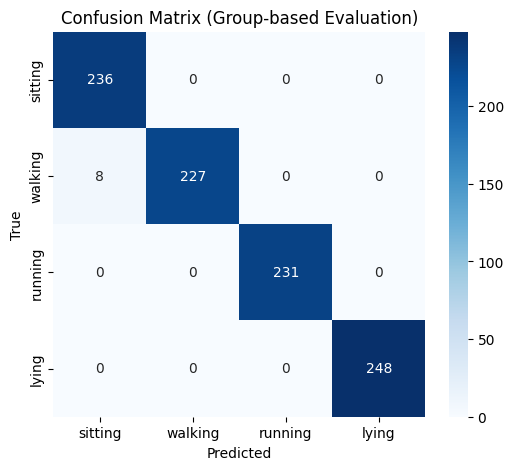

In [4]:
# ===== 4. Train and Evaluate the Logistic Regression Model =====
# In this part, we train a Logistic Regression model and check its performance
# using accuracy, F1-score, and a confusion matrix.

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pipeline: scaling + model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# 5-fold cross-validation using GroupKFold (based on participant_id)
groups = data["participant_id"]
gkf = GroupKFold(n_splits=5)

scores = cross_validate(pipe, X, y, groups=groups, cv=gkf,
                        scoring=["accuracy", "f1_macro"], n_jobs=-1)

print(f"CV (Group) Accuracy: {scores['test_accuracy'].mean():.3f} ± {scores['test_accuracy'].std():.3f}")
print(f"CV (Group) F1-macro: {scores['test_f1_macro'].mean():.3f} ± {scores['test_f1_macro'].std():.3f}")

# Train on full training set
pipe.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipe.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-macro:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['sitting','walking','running','lying'],
            yticklabels=['sitting','walking','running','lying'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Group-based Evaluation)")
plt.show()

In [5]:
# ===== Metrics Table for Logistic Regression =====

results_logreg = pd.DataFrame({
    "CV_acc_mean": [scores["test_accuracy"].mean()],
    "CV_acc_std":  [scores["test_accuracy"].std()],
    "CV_f1_mean":  [scores["test_f1_macro"].mean()],
    "CV_f1_std":   [scores["test_f1_macro"].std()],
    "Test_acc":    [accuracy_score(y_test, y_pred)],
    "Test_f1":     [f1_score(y_test, y_pred, average='macro')]
})

print("\n📊 Metrics Table (Logistic Regression):")
results_logreg



📊 Metrics Table (Logistic Regression):


,CV_acc_mean,CV_acc_std,CV_f1_mean,CV_f1_std,Test_acc,Test_f1
0,0.946888,0.090514,0.930969,0.122277,0.991579,0.991504


In [6]:
# ===== 5. Hyperparameter Tuning for Logistic Regression =====
# Simple hyperparameter tuning using GridSearchCV with GroupKFold.

from sklearn.model_selection import GridSearchCV, GroupKFold

# Recreate the pipeline: StandardScaler + Logistic Regression
pipe_tune = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# Parameter search space for Logistic Regression
param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Use participant_id groups to avoid data leakage
groups = data["participant_id"]
gkf = GroupKFold(n_splits=5)

# Grid search setup
grid = GridSearchCV(
    estimator=pipe_tune,
    param_grid=param_grid,
    cv=gkf,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=False
)

# Run the grid search
grid.fit(X, y, groups=groups)

# Display the best parameters
print("Best parameters:", grid.best_params_)
print("Best CV F1-macro:", grid.best_score_)

# Create a summary table of all tuning results
tuning_results = pd.DataFrame({
    "C": [p["clf__C"] for p in grid.cv_results_["params"]],
    "mean_f1": grid.cv_results_["mean_test_score"],
    "std_f1": grid.cv_results_["std_test_score"]
})

print("\nHyperparameter tuning results (sorted):")
tuning_results.sort_values("mean_f1", ascending=False)


Best parameters: {'clf__C': 10.0}
Best CV F1-macro: 0.94633617906086

Hyperparameter tuning results (sorted):


,C,mean_f1,std_f1
3,10.00,0.946336,0.084751
0,0.01,0.931141,0.127245
2,1.00,0.930969,0.122277
1,0.10,0.929697,0.129590
4,100.00,0.926380,0.109797


In [7]:
best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(C=10, max_iter=2000, solver="lbfgs"))
])

best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)

print("Accuracy (best C):", accuracy_score(y_test, y_pred_best))
print("F1-macro (best C):", f1_score(y_test, y_pred_best, average='macro'))


Accuracy (best C): 0.9789473684210527
F1-macro (best C): 0.9787262872628726


In [8]:
# ===== 6. Error Analysis for Logistic Regression (best C) =====

# Identify misclassified samples
misclassified_mask = y_test != y_pred_best

errors_df = X_test.copy()
errors_df["true_label"] = y_test.values
errors_df["pred_label"] = y_pred_best

# Optional: map numeric labels to activity names
label_map = {1: "sitting", 2: "walking", 3: "running", 4: "lying"}
errors_df["true_activity"] = errors_df["true_label"].map(label_map)
errors_df["pred_activity"] = errors_df["pred_label"].map(label_map)

num_errors = misclassified_mask.sum()
print(f"Number of misclassified samples: {num_errors}")
print("\nExamples of misclassified samples:")
errors_df[misclassified_mask].head()


Number of misclassified samples: 20

Examples of misclassified samples:


,ax_mean,ax_std,ax_max,ax_min,ax_range,ax_skew,ax_kurt,ax_zcr,ay_mean,ay_std,...,Gx,Gy,Gz,Gx_angle,Gy_angle,Gz_angle,true_label,pred_label,true_activity,pred_activity
1199,0.020711,0.096424,0.152797,-0.257281,0.410078,-1.662080,3.323173,7,0.019574,0.097184,...,-0.038510,-0.987787,0.150975,1.609316,2.985146,1.419242,2,1,walking,sitting
1200,-0.007602,0.060578,0.090578,-0.201026,0.291604,-1.532538,3.796724,6,0.010268,0.122206,...,-0.039137,-0.987876,0.150233,1.609944,2.985715,1.419992,2,1,walking,sitting
1208,-0.009125,0.086382,0.130342,-0.219970,0.350312,-0.246922,0.144827,10,0.022758,0.116779,...,-0.049123,-0.987573,0.149288,1.619940,2.983776,1.420948,2,1,walking,sitting
1216,-0.015652,0.067444,0.098969,-0.133997,0.232966,0.119439,-0.876987,8,0.028781,0.111936,...,-0.030796,-0.987942,0.151728,1.601597,2.986146,1.418480,2,1,walking,sitting
1226,-0.035884,0.071100,0.064103,-0.191910,0.256013,-0.682710,-0.546837,10,-0.019824,0.139613,...,-0.041816,-0.986192,0.160238,1.612624,2.975222,1.409865,2,1,walking,sitting


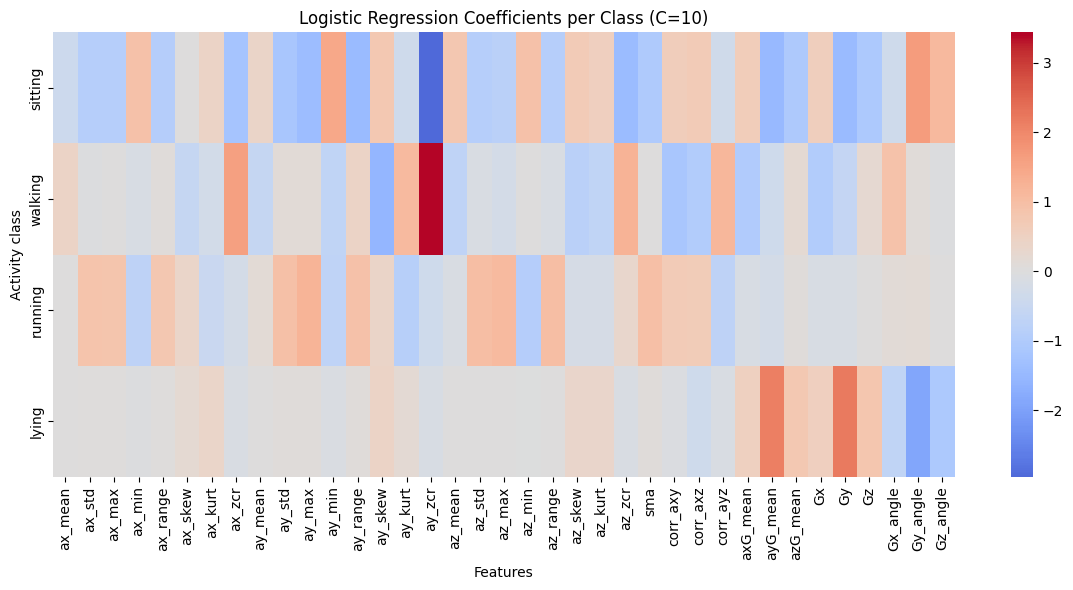

In [9]:
# ===== 7. Interpretability: Logistic Regression Coefficients =====

# Get the trained logistic regression model from the pipeline
clf_best = best_pipe.named_steps["clf"]

# Coefficients shape: (n_classes, n_features)
coefs = clf_best.coef_
feature_names = X.columns
class_ids = clf_best.classes_

# Map class ids to activity names for readability
class_names = [label_map[c] for c in class_ids]

coef_df = pd.DataFrame(
    coefs,
    index=class_names,
    columns=feature_names
)

plt.figure(figsize=(12, 6))
sns.heatmap(coef_df, cmap="coolwarm", center=0)
plt.title("Logistic Regression Coefficients per Class (C=10)")
plt.xlabel("Features")
plt.ylabel("Activity class")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Participants: ['LL' 'VV' 'YL' 'YT' 'ZM']

Processing participant: LL
Fold accuracy for LL: 0.9840

Classification report:
              precision    recall  f1-score   support

           1      1.000     0.937     0.968       239
           2      0.939     1.000     0.969       231
           3      1.000     1.000     1.000       237
           4      1.000     1.000     1.000       229

    accuracy                          0.984       936
   macro avg      0.985     0.984     0.984       936
weighted avg      0.985     0.984     0.984       936



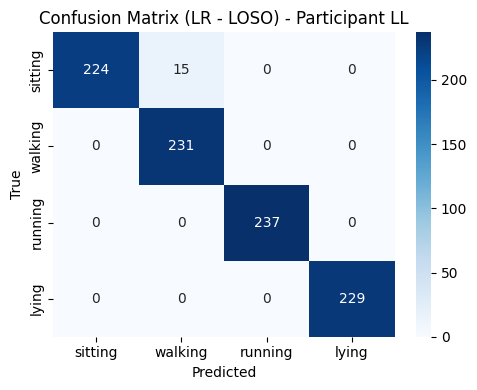


Processing participant: VV
Fold accuracy for VV: 0.9789

Classification report:
              precision    recall  f1-score   support

           1      0.922     1.000     0.959       236
           2      1.000     0.915     0.956       235
           3      1.000     1.000     1.000       231
           4      1.000     1.000     1.000       248

    accuracy                          0.979       950
   macro avg      0.980     0.979     0.979       950
weighted avg      0.981     0.979     0.979       950



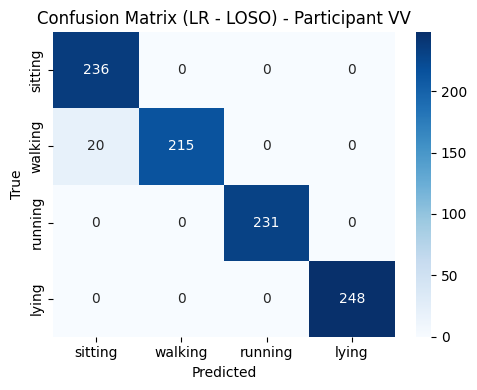


Processing participant: YL
Fold accuracy for YL: 0.9916

Classification report:
              precision    recall  f1-score   support

           1      0.971     1.000     0.985       234
           2      0.996     0.970     0.983       234
           3      1.000     0.996     0.998       245
           4      1.000     1.000     1.000       244

    accuracy                          0.992       957
   macro avg      0.992     0.992     0.991       957
weighted avg      0.992     0.992     0.992       957



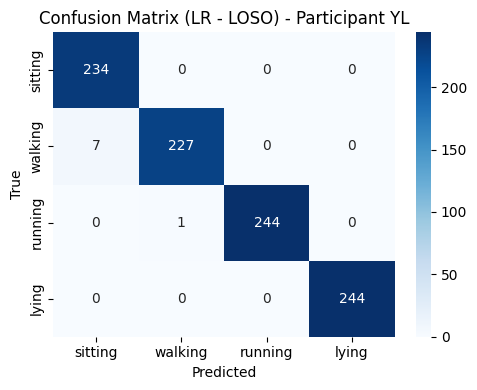


Processing participant: YT
Fold accuracy for YT: 1.0000

Classification report:
              precision    recall  f1-score   support

           1      1.000     1.000     1.000       243
           2      1.000     1.000     1.000       237
           3      1.000     1.000     1.000       237
           4      1.000     1.000     1.000       237

    accuracy                          1.000       954
   macro avg      1.000     1.000     1.000       954
weighted avg      1.000     1.000     1.000       954



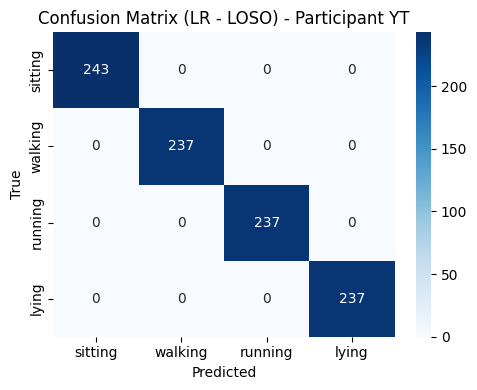


Processing participant: ZM
Fold accuracy for ZM: 0.8113

Classification report:
              precision    recall  f1-score   support

           1      1.000     1.000     1.000       253
           2      0.560     1.000     0.718       229
           3      1.000     1.000     1.000       234
           4      1.000     0.244     0.392       238

    accuracy                          0.811       954
   macro avg      0.890     0.811     0.777       954
weighted avg      0.894     0.811     0.781       954



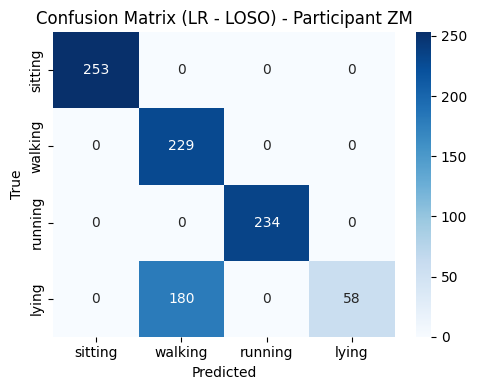

In [ ]:
# ===== 8. LOSO Evaluation for Logistic Regression (per participant) =====

# We reuse: data, X, y, best_pipe, accuracy_score, classification_report,
# confusion_matrix, plt, sns (already imported above)

participants = data["participant_id"].unique()
print("Participants:", participants)

for p in participants:
    print("\n" + "="*60)
    print(f"Processing participant: {p}")

    # LOSO split: this participant is test, others are train
    test_mask = data["participant_id"] == p
    train_mask = ~test_mask

    X_train_p = X[train_mask]
    y_train_p = y[train_mask]
    X_test_p = X[test_mask]
    y_test_p = y[test_mask]

    # Fit LR with best C on other participants
    best_pipe.fit(X_train_p, y_train_p)

    # Predict on this participant
    y_pred_p = best_pipe.predict(X_test_p)

    # Metrics
    acc_p = accuracy_score(y_test_p, y_pred_p)
    print(f"Fold accuracy for {p}: {acc_p:.4f}")

    print("\nClassification report:")
    print(classification_report(y_test_p, y_pred_p, digits=3))

    # Confusion matrix
    cm_p = confusion_matrix(y_test_p, y_pred_p, labels=[1, 2, 3, 4])
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_p,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["sitting", "walking", "running", "lying"],
        yticklabels=["sitting", "walking", "running", "lying"],
    )
    plt.title(f"Logistic Regression - {p}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    filepath = f"../results/cm_lr_{p}.png"
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

    plt.show()
